In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma4 = np.array([1, 0, 0, 0, 0])
ar4 = np.array([1, -0.4, -0.3, -0.15, -0.1])   # Coefficient oposite signs to those we wish to simulate
# Quick stability verification: the sum of the absolute values of the AR coefficients should be less than 1: |0.5| + |0.2| + |0.1| + |0.05| = 0.85 < 1

AR4_process = ArmaProcess(ar4, ma4).generate_sample(nsample=10000)
print(type(AR4_process), AR4_process.shape, type(AR4_process[0]))
AR4_process[:9]

<class 'numpy.ndarray'> (10000,) <class 'numpy.float64'>


array([0.49671415, 0.06042136, 0.82087133, 1.94401192, 0.84844741,
       0.81761842, 2.53448333, 2.34818189, 1.43763087])

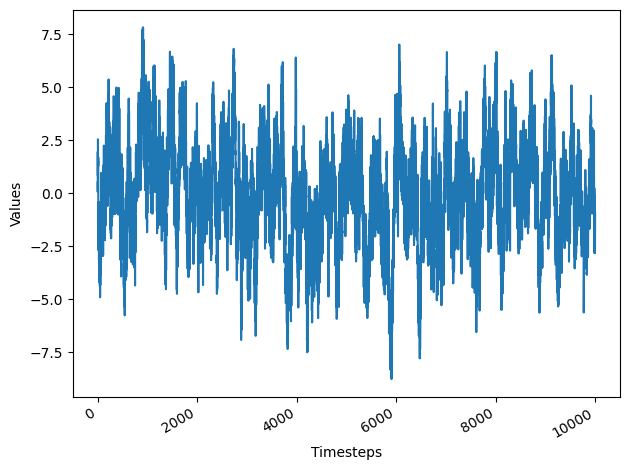

In [3]:
fig, ax = plt.subplots()

ax.plot(AR4_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(AR4_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows stationarity

ADF Statistic: -11.237473702160294
p-value: 1.842012492584458e-20


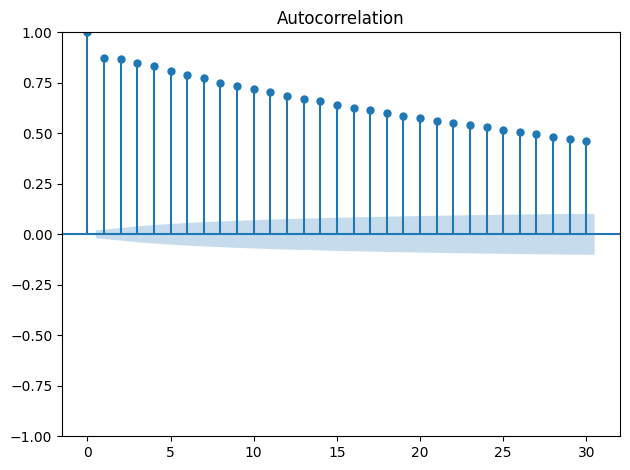

In [5]:
plot_acf(AR4_process, lags=30)

plt.tight_layout()

ACF is slowly decaying

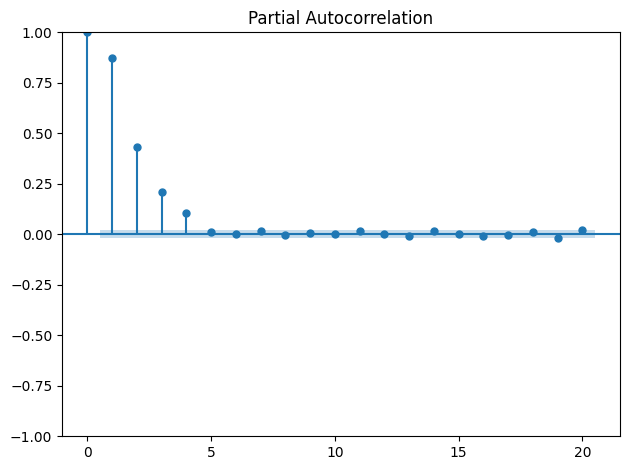

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR4_process, lags=20);

#plt.ylim(-0.2,0.5)

plt.tight_layout()

No significant coefficients after lag 4

We could use a AR(4) model

In [7]:
df = pd.DataFrame({'Values': AR4_process})

train = df[:-200]
test = df[-200:]

print(len(train))
print(len(test))

9800
200


In [8]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean[:horizon]   # In last iteration of the for loop, the second for will act window times, even if there is no room for all

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value[:horizon]   # In last iteration of the for loop, the second for will act window times, even if there is no room for all
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))      #  The order specifies an AR(3) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR[:horizon] 

In [9]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,Values,pred_mean,pred_last_value,pred_AR
9800,-0.926350,-0.033750,-2.555973,-1.819734
9801,-0.996129,-0.033841,-0.926350,-1.542069
9802,1.089674,-0.033939,-0.996129,-1.244858
9803,-1.273100,-0.033824,1.089674,-0.076982
9804,0.398180,-0.033951,-1.273100,-0.369169


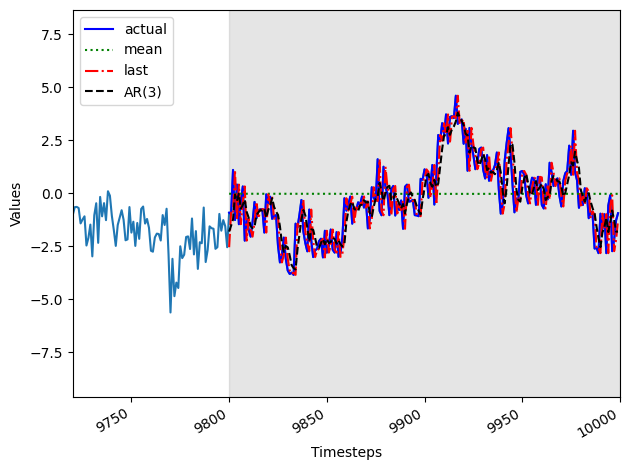

In [10]:
fig, ax = plt.subplots()

ax.plot(df['Values'])
ax.plot(test['Values'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9720, 10000)

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['Values'], test['pred_mean'])
mse_last = mean_squared_error(test['Values'], test['pred_last_value'])
mse_AR = mean_squared_error(test['Values'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

2.996247126166269 1.0841518877981235 0.9124313300818


np.random.seed(42)  
ma4 = np.array([1, 0, 0, 0, 0])  
ar4 = np.array([1, -0.4, -0.3, -0.15, -0.1]) 
AR4_process = ArmaProcess(ar4, ma4).generate_sample(nsample=10000)  

print(mse_mean, mse_last, mse_AR)  

WINDOW=4  
2.9969427472524344 1.5662022982531163 1.1480025883465896  
WINDOW=3  
2.9967223581626534 1.5812902498169352 1.1538049703722608  
WINDOW=2  
2.996498065567643 1.3030007792755194 1.0403822159304799  
WINDOW=1  
2.996247126166269 1.0841518877981235 0.9124313300818

My champion model is AR(4)  

np.random.seed(42)  
ma4 = np.array([1, 0, 0, 0, 0])  
ar4 = np.array([1, -0.6, +0.3, -0.15, +0.1])   
AR4_process = ArmaProcess(ar4, ma4).generate_sample(nsample=10000)  

print(mse_mean, mse_last, mse_AR)  

WINDOW=4  
1.402575993755002 3.336264726384901 1.2981372935288158  
WINDOW=3  
1.4026035752906676 2.9156412747340337 1.2223093097479876  
WINDOW=2  
1.402594069665496 2.147176538882482 1.1887853230542456  
WINDOW=1  
1.4025225506211803 1.3704411220880166 0.9338114134451281   

My champion model is AR(4)  

np.random.seed(42)  
ma4 = np.array([1, 0, 0, 0, 0])  
ar4 = np.array([1, -0.2, +0.1, -0.5, +0.05])  
AR4_process = ArmaProcess(ar4, ma4).generate_sample(nsample=10000)  

print(mse_mean, mse_last, mse_AR)  

WINDOW=4  
1.1139201004563457 2.3698895282363175 1.0206830396294715  
WINDOW=3  
1.1139143670122862 1.9802274332496814 0.9547468378434183  
WINDOW=2  
1.1139092057560722 2.2248964201060035 0.9560073394865488  
WINDOW=1  
1.1138867018692382 1.823540470635914 0.915708393682207  

My champion model is AR(4)  

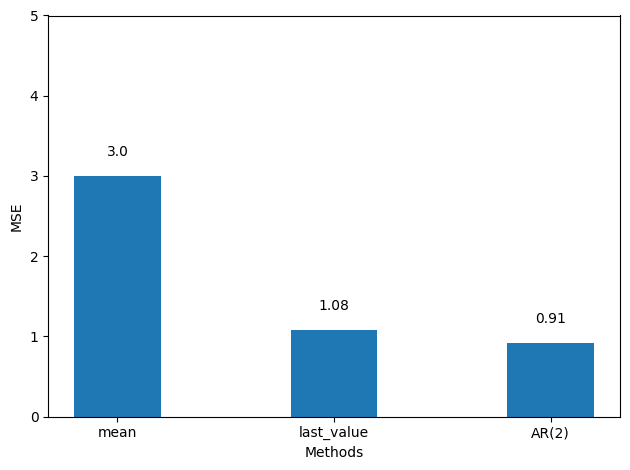

In [12]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()